# Trabajo Práctico 2 : Críticas cinematográficas N1

# Grupo: GPWin - N° 16

Integrantes:

- DIEM, Walter Gabriel

- MAIOLO, Alejandro

## Resumen

En esta notebook se exploran los siguientes modelos:
- Un modelo Naive Bayes default con count vectorizer
- Un modelo Naive Bayes con optimización de hiperparámetros bayesiana del modelo y del vectorizer (count vectorizer + tfidf transformer)
- Un modelo Random Forest con optimización de hiperparámetros bayesiana del modelo y del vectorizer (count vectorizer + tfidf transformer)
- Un modelo XGBoost con optimización de hiperparámetros bayesiana del modelo y del vectorizer (count vectorizer + tfidf transformer)

## Exploración de datos

Preparación de librerías

In [1]:
#%pip install joblib optuna

In [4]:
import xgboost
from xgboost import XGBClassifier

In [2]:
import pandas as pd
import numpy as np
import tensorflow as tf
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
import re
import optuna

from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.pipeline import Pipeline

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score, recall_score, accuracy_score,f1_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import make_scorer, f1_score
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

Seteo de semillas para mejor reproducción de resultados

In [6]:
np.random.seed(1)
tf.random.set_seed(1)

In [5]:
xgboost.config_context(verbosity=2)

### Prepocesamiento de datos

Exploramos el dataset de train y test

In [8]:
critics = pd.read_csv("./datasets/train.csv")
critics.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   ID           50000 non-null  int64 
 1   review_es    50000 non-null  object
 2   sentimiento  50000 non-null  object
dtypes: int64(1), object(2)
memory usage: 1.1+ MB


In [9]:
criticsTest = pd.read_csv("./datasets/test.csv")
criticsTest.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8599 entries, 0 to 8598
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   ID         8599 non-null   int64 
 1   review_es  8599 non-null   object
dtypes: int64(1), object(1)
memory usage: 134.5+ KB


Tenemos 50k críticas para train y 8.6k entradas para test en Kaggle. Imprimimos una muestra para ver cómo son.

In [10]:
for critic in critics.sample(20)["review_es"]:
    print("###---###")
    print(critic)

###---###
Sin héroes muertos, se obtienen líneas estúpidas como esa, ya que se debe ver esta película de acción lamentablemente abismal. William Sanders es salvada por su amigo Harry Cotter durante una extracción en Vietnam, pero el enemigo capturado por el enemigo. Avance rápido de diez años y Harry ahora es un operario ruso en lavado de cerebro con un microchip de control mental implantado en su cerebro. Su nuevo Superior Ruso es Ivan jugó a la empuñadura obscena por Nick Nicholson, quien podría agregar no solo no intenta hablar con un acento ruso, sino que se parece a más un asistente de gasolina en Kentucky con sus dientes manchados. Lo que es aún más absurdo es el hecho de que también fue el entrenador de diálogo para esta película. Pronto William es re-reclutado por la CIA para cazar a Harry. Se adapta a Barbara, un luchador por la libertad que ha infiltrado el campamento de El Salvador de Ivan y pronto los dos están soplando la mitad de América del Sur. Algunas escenas son tan h

Cambiamos el nombre de la columna `review_es` a sólo `review`

In [11]:
critics.rename(columns={"review_es": "review"}, inplace=True)
critics.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   ID           50000 non-null  int64 
 1   review       50000 non-null  object
 2   sentimiento  50000 non-null  object
dtypes: int64(1), object(2)
memory usage: 1.1+ MB


Revisamos valores nulos

In [12]:
criticsNull = critics.isnull().any()
criticsNull

ID             False
review         False
sentimiento    False
dtype: bool

No hay valores nulos en el dataset. Revisamos el balance entre reviews negativas y positivas 

In [13]:
critics["sentimiento"].value_counts()

positivo    25000
negativo    25000
Name: sentimiento, dtype: int64

Hay la misma cantidad de reviews positivas y negativas

Hacemos una función que a cada review le pasará a minúscula las palabras que no estén completamente escritas es mayúsculas

In [14]:
def toLowercaseIfNotFullyUppercase(review):
    words = review.split()
    parsedReview = []

    for word in words:
        if word.isupper():
            parsedReview.append(word)
        else:
            parsedReview.append(word.lower())

    return ' '.join(parsedReview)

In [15]:
critics["review"].apply(toLowercaseIfNotFullyUppercase)

0        uno de los otros críticos ha mencionado que de...
1        una pequeña pequeña producción.la técnica de f...
2        pensé que esta era una manera maravillosa de p...
3        básicamente, hay una familia donde un niño peq...
4        el "amor en el tiempo" de petter mattei es una...
                               ...                        
49995    pensé que esta película hizo un buen trabajo a...
49996    mala parcela, mal diálogo, mala actuación, dir...
49997    soy católica enseñada en escuelas primarias pa...
49998    voy a tener que estar en desacuerdo con el com...
49999    nadie espera que las películas de star trek se...
Name: review, Length: 50000, dtype: object

Encodeamos con LabelEncoder a los sentimientos

In [16]:
labelEncoder = LabelEncoder()
labelEncoder.fit(critics["sentimiento"])

print("Encoding queda:")
print(f"0 = {labelEncoder.inverse_transform([0])[0]}\n1 = {labelEncoder.inverse_transform([1])[0]}")

Encoding queda:
0 = negativo
1 = positivo


In [17]:
critics["sentimiento"] = labelEncoder.transform(critics["sentimiento"])
critics["sentimiento"].sample(4)

45997    0
9976     1
48042    0
3714     0
Name: sentimiento, dtype: int64

Creamos una función que remueva caracteres que no sean una palabra con espacios y los cambiamos por un espacio

In [18]:
def removePunctuation(review):
    return re.sub(r'[^\w\s]', ' ', review)

In [19]:
critics["review"] = critics["review"].apply(removePunctuation)
critics["review"].sample(10)

20895    El único bien  ya sea de los problemas  las pe...
35913    Si bien esto está horriblemente anticuado  deb...
29522    Mark Frechette Estrella como Mark  una univers...
8761     Si es cierto que el sadomasoquismo es una mone...
49943     SIR  ha jugado a LEAR más de 200 veces  pero ...
851      Steven Seagal s films of late have not exactly...
31578     Paso  Hanna Barbera de los años 60 y 70   Qué...
33833    Desde los primeros 10 segundos de tono de negr...
22722    Esta es la peor película absoluta que he visto...
23456    Después de haber visto al cazador de ciervos  ...
Name: review, dtype: object

### Split

Hacemos el split de train y test con relación de ~1/6

In [20]:
critics_x = critics["review"].copy()
critics_y = critics["sentimiento"].copy()

x_train, x_test, y_train, y_test = train_test_split(critics_x,
                                                    critics_y,
                                                    test_size=0.18,
                                                    random_state=0)

### Procesamos conjunto de test de Kaggle

Con el dataset que submitearemos a Kaggle, lo importamos y la hacemos los mismos cambios que se le hicieron al conjunto de training

In [21]:
criticsTest = pd.read_csv("./datasets/test.csv")
criticsTest.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8599 entries, 0 to 8598
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   ID         8599 non-null   int64 
 1   review_es  8599 non-null   object
dtypes: int64(1), object(1)
memory usage: 134.5+ KB


Le cambiamos el nombre a la columna review

In [22]:
criticsTest.rename(columns={"review_es": "review"}, inplace=True)
criticsTest.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8599 entries, 0 to 8598
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   ID      8599 non-null   int64 
 1   review  8599 non-null   object
dtypes: int64(1), object(1)
memory usage: 134.5+ KB


Procesamos las mayúsculas y minúsculas

In [23]:
criticsTest["review"].apply(toLowercaseIfNotFullyUppercase)

0       la mayor virtud de esta película es su existen...
1       no soy un experto cinéfilo, pero pocas veces m...
2       si no eres un incondicional del humor estilo t...
3       no sé qué está pasando, si la gente se deja ll...
4       pero cuando amanece,y me quedo solo,siento en ...
                              ...                        
8594    buena no, lo siguiente. por fin un film serio ...
8595    me esperaba mucho, pero que mucho, más.guión m...
8596    de mal cuerpo como sensación al finalizar, de ...
8597    los que han añadido comentarios os lo han dich...
8598    fui a ver esta película de cine con entusiasmo...
Name: review, Length: 8599, dtype: object

Procesamos los signos de puntación

In [24]:
criticsTest["review"] = criticsTest["review"].apply(removePunctuation)
criticsTest["review"].sample(10)

7494    Hace ya algún tiempo que se estreno este éxito...
8078    Comedia española con claras intenciones amable...
82      Sobrevalorada comedía que no ofrece nada nuevo...
187     La película más taquillera de la historia del ...
3495    Aviso a vuesas mercedes Acaba de estrenarse Al...
2108    En un principio puede parecer incluso interesa...
4271    Celda 211 es una película sobrevalorada  Tiene...
8168    Cuando una película funciona y no hay ideas y ...
6135    De las peores películas que he visto en los ul...
6290    Yo creo que si el señor Amenábar estuviera en ...
Name: review, dtype: object

## Modelo Naive Bayes default

Creamos una pipeline que se encargará de realizar una vectorización siguiendo el modelo de BoW (Bag of Words) con el CountVectorizer y posteriormente se aplicará un naive bayes para multinomiales.

La forma en que una pipeline funciona es mediante pasos secuenciales, donde el último paso es un predictor y el resto son transformadores de datos. Al realizar el fit de la pipeline, los transformadores realizarán un fit_transform y el predictor un fit. Al realizar el predict de la pipeline, los transofmradores realizarán un transform y el predictor un predict.

En este caso el predictor es el naive bayes multinomial MultinomialNB y el transformador es el CountVectorizer. Ambos con sus parámetros default.

In [24]:
multinomialNBPipeline = Pipeline(steps=[
  ('vectorizer', CountVectorizer()),
  ('multinomialNB', MultinomialNB())
])

Entrenamos al modelo y la pipeline

In [25]:
runNumber = 1

multinomialNBPipeline.fit(x_train, y_train)

Pipeline(steps=[('vectorizer', CountVectorizer()),
                ('multinomialNB', MultinomialNB())])

In [26]:
multinomialNBPipeline.get_params()

{'memory': None,
 'steps': [('vectorizer', CountVectorizer()),
  ('multinomialNB', MultinomialNB())],
 'verbose': False,
 'vectorizer': CountVectorizer(),
 'multinomialNB': MultinomialNB(),
 'vectorizer__analyzer': 'word',
 'vectorizer__binary': False,
 'vectorizer__decode_error': 'strict',
 'vectorizer__dtype': numpy.int64,
 'vectorizer__encoding': 'utf-8',
 'vectorizer__input': 'content',
 'vectorizer__lowercase': True,
 'vectorizer__max_df': 1.0,
 'vectorizer__max_features': None,
 'vectorizer__min_df': 1,
 'vectorizer__ngram_range': (1, 1),
 'vectorizer__preprocessor': None,
 'vectorizer__stop_words': None,
 'vectorizer__strip_accents': None,
 'vectorizer__token_pattern': '(?u)\\b\\w\\w+\\b',
 'vectorizer__tokenizer': None,
 'vectorizer__vocabulary': None,
 'multinomialNB__alpha': 1.0,
 'multinomialNB__class_prior': None,
 'multinomialNB__fit_prior': True,
 'multinomialNB__force_alpha': 'warn'}

Realizamos la predicción con el split de test

In [27]:
y_pred = multinomialNBPipeline.predict(x_test)

Imprimimos la matriz de confusión. Se agrega una caja de texto con las equivalencias entre las etiquetas numéricas y el sentimiento

F1-Score: 0.8282922289436948


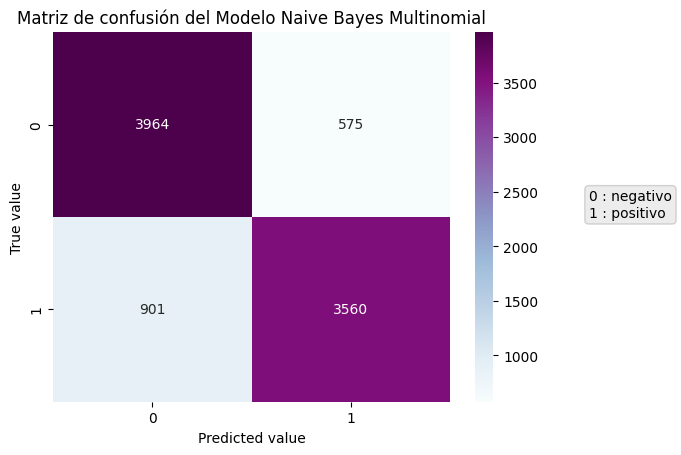

In [28]:
print('F1-Score: {}'.format(f1_score(y_test, y_pred, average='binary')))

confussionMatrix = confusion_matrix(y_true=y_test, y_pred=y_pred)
sns.heatmap(confussionMatrix,cmap='BuPu', annot=True, fmt='g')
plt.xlabel('Predicted value')
plt.ylabel('True value')
plt.title("Matriz de confusión del Modelo Naive Bayes Multinomial")
plt.text(2.7, 1, f"0 : {labelEncoder.inverse_transform([0])[0]}\n1 : {labelEncoder.inverse_transform([1])[0]}", bbox=dict(boxstyle='round', facecolor='grey', alpha=0.15))
plt.show()

Mostramos las distintas métricas

In [29]:
accuracy = accuracy_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)

print(f"Accuracy: {str(accuracy)}")
print(f"Recall: {str(recall)}")
print(f"Precision: {str(precision)}")
print(f"f1 score: {str(f1)}")

Accuracy: 0.836
Recall: 0.7980273481282224
Precision: 0.8609431680773881
f1 score: 0.8282922289436948


Realizamos las predicciones de los datos que vamos a submitear a kaggle

In [30]:
y_pred = multinomialNBPipeline.predict(criticsTest["review"])

Agrupamos en el dataframe los valores predichos decodeados con el label encoder

In [31]:
kaggleResult = criticsTest.copy()
kaggleResult.drop(columns=["review"], inplace=True)

kaggleResult["sentimiento"] = labelEncoder.inverse_transform(y_pred)

kaggleResult.head(2)

,ID,sentimiento
0,60000,negativo
1,60001,negativo


Para exportar a Kaggle exportamos el csv. El `runNumber` es sólo un número que ponemos para no pisar los submits

In [32]:
kaggleResult.to_csv(f"submit_{runNumber}_grupo16_gpwin_naive_bayes_multinomial.csv", index=False)

Guardamos una serialización del modelo

In [33]:
filename = f'./naive_bayes_multinomial_model_{runNumber}.joblib'
modelInfo = {'model': multinomialNBPipeline}

joblib.dump(modelInfo, filename)

['./naive_bayes_multinomial_model_1.joblib']

## Modelo Naive Bayes con optimización de hiperparámetros

Creamos una pipeline que se encargará de realizar una vectorización siguiendo el modelo de BoW (Bag of Words) con el CountVectorizer, un transformador intermedio TfidfTransformer y posteriormente se aplicará un naive bayes para multinomiales.

El transformador TfidfTransformer normaliza la matriz del CountVectorizer por term-frequency (tf) o por term-frequency times inverse document-frequency (tf-idf), este último penaliza los tokens que se repiten mucho que usualmente no cargan con mucha información, como por ejemplo artículos.

Al aplicar este transformador luego del CountVectorizer, durante la optimización de hiperparámetros, se puede modificar el funcionamiento del transformador, incluso desactivándolo y utilizando el resultado del CountVectorizer directamente.

Se realizará una optimitimización de hiperparámetros de forma bayesiana con la librería optuna, de la misma manera que se hizo en el TP1. Dejamos un resumen del funcionamiento, que fue parte de la entrega del checkpoint 3 del TP1: 

- La optimización bayesiana es un enfoque efectivo para optimizar hiperparámetros, ya que a diferencia de los métodos de grid search y random search, aprovecha los resultados de evaluaciones previas para tomar decisiones más inteligentes sobre el siguiente conjunto de hiperparámetros a explorar. Trata la búsqueda de hiperparámetros óptimos como un problema de optimización, guiado por un modelo probabilístico que estima la probabilidad de lograr un resultado deseado con una combinación particular de hiperparámetros. Este enfoque reduce la cantidad de evaluaciones de la función objetivo necesarias para encontrar una buena solución, lo que lo hace especialmente valioso cuando la función objetivo es desconocida, que suele ser el caso. Varios modelos probabilísticos, como los procesos gaussianos, la regresión de random forests y los estimadores de Parzen estructurados en árboles (tree-structured Parzen estimators -TPE), sirven como modelos sustitutos para acelerar el proceso de optimización.

- Usaremos la librería optuna que automatiza y agiliza el proceso de ajuste de hiperparámetros, esta es la que utiliza técnicas de optimización bayesiana mencionada anteriormente, para recorrer el espacio de hiperparámetros de manera eficiente. Uno de sus fuertes es que es agnóstica al framework, por lo que se puede utilizar con diversos modelos de machine learning. 

Hay 3 grupos de hiperparámetros que optimizaremos: los del CountVectorizer, los del transformer Tfidf y los del modelo naive bayes multinomial.

Para el CountVectorizer optimizamos:
- strip_accents: forma de transformar los caracteres con tildes, puede ser utilizando una representación ascii, unicode o no hacer ninguna tranformación
- lowercase: pasa todos los caracteres a minúscula, puede estar activado o desactivado
- ngram_range: cantidad de n-gramas a utilizar para la tokenización, tomamos que puede ser unigramas, bigramas o ambos
- binary: si está en true, todas las cuentas que son distintas de cero se ponen en 1, puede servir porque estamos modelando un evento binario
- analyzer: lo tendremos seteado en word, así que un unigrama será una palabra y un bigrama serán dos palabras

Para el transformer Tfidf optimizamos:
- norm: tipo de normalización, puede estar desactivado o ser l1 (suma de los valores absolutos de las componentes del vector es 1) o l2 (suma de los valores absolutos al cuadrado de las componentes del vector es 1)
- use_idf: habilita o desabilita el uso del inverse document frequency
- sublinear_tf: aplica un escalado de term frequency sublineal, lo reemplaza por 1 + log(tf)

Para el modelo naive bayes multinomial optimizamos:
- alpha: parámetro de suavizado aditivo Laplace/Lidstone
- force_alpha: forzar el alpha si es muy pequeño

Creamos la función objetivo que vamos a optimizar

In [29]:
def objective(trial):

    parametersVectorizer = {
        'strip_accents': trial.suggest_categorical('strip_accents', ['ascii', 'unicode', None]),
        'lowercase': trial.suggest_categorical('lowercase', [True, False]),
        'ngram_range': trial.suggest_categorical('ngram_range', [(1,1), (1,2), (2,2)]),
        'binary': trial.suggest_categorical('binary', [True, False]),
        'analyzer': 'word'
    }

    parametersTransformer = {
        'norm': trial.suggest_categorical('norm', ['l1', 'l2', None]),
        'use_idf': trial.suggest_categorical('use_idf', [True, False]),
        'sublinear_tf': trial.suggest_categorical('sublinear_tf', [True, False]),
    }

    parametersModel = {
        'alpha': trial.suggest_loguniform('alpha', 1e-8, 1.0),
        'force_alpha': trial.suggest_categorical('force_alpha', [True, False]),
    }

    multinomialNBPipeline = Pipeline(steps=[
        ('vectorizer', CountVectorizer(**parametersVectorizer)),
        ('tfidfTransformer', TfidfTransformer(**parametersTransformer)),
        ('multinomialNB', MultinomialNB(**parametersModel))
    ])

    multinomialNBPipeline.fit(x_train, y_train)
    y_pred = multinomialNBPipeline.predict(x_test)

    return f1_score(y_test, y_pred, average='binary')


Creamos un study que va a ser donde corramos el "estudio de maximizar la función objetivo" definida arriba (que optimiza el f1 score)

In [30]:
study = optuna.create_study(direction='maximize')

[I 2023-11-19 08:02:04,808] A new study created in memory with name: no-name-6607a62c-63e8-439d-aa86-af4fc2eb559e


El método de sampleo de hiperparámetros que seguirá la optimización bayesiana será con el tree-structured Parzen estimators -TPE

In [31]:
study.sampler.__class__.__name__

'TPESampler'

Ejecutamos el estudio

In [ ]:
study.optimize(objective, n_trials=200, n_jobs=3)

Las 200 iteraciones del estudio tardaron 70 minutos en total

Seleccionamos el mejor trial (intento) con el mejor score y el mejor conjunto de hiperparámetros

In [33]:
bestTrial = study.best_trial
bestScore = bestTrial.value
hyperparameters = bestTrial.params

print('Cantidad de trials total: {}'.format(len(study.trials)))
print('Mejor f1score: ' + str(bestScore) + "\n")

for param, value in hyperparameters.items():
    print(f"{param}: {value}")

Cantidad de trials total: 200
Mejor f1score: 0.8844444444444444

strip_accents: ascii
lowercase: False
ngram_range: (1, 2)
binary: True
norm: l1
use_idf: True
sublinear_tf: True
alpha: 0.00473836153395484
force_alpha: False


Recreamos una pipeline con estos mejores parámetros

In [34]:
runNumber = 4

parametersVectorizer = {
    'strip_accents': hyperparameters["strip_accents"],
    'lowercase': hyperparameters["lowercase"],
    'ngram_range': hyperparameters["ngram_range"],
    'binary': hyperparameters["binary"],
    'analyzer': 'word'
}

parametersTransformer = {
    'norm': hyperparameters["norm"],
    'use_idf': hyperparameters["use_idf"],
    'sublinear_tf': hyperparameters["sublinear_tf"],
}

parametersModel = {
    'alpha': hyperparameters["alpha"],
    'force_alpha': hyperparameters["force_alpha"],
}

multinomialNBPipeline = Pipeline(steps=[
    ('vectorizer', CountVectorizer(**parametersVectorizer)),
    ('tfidfTransformer', TfidfTransformer(**parametersTransformer)),
    ('multinomialNB', MultinomialNB(**parametersModel))
])

multinomialNBPipeline.fit(x_train, y_train)

Pipeline(steps=[('vectorizer',
                 CountVectorizer(binary=True, lowercase=False,
                                 ngram_range=(1, 2), strip_accents='ascii')),
                ('tfidfTransformer',
                 TfidfTransformer(norm='l1', sublinear_tf=True)),
                ('multinomialNB',
                 MultinomialNB(alpha=0.00473836153395484, force_alpha=False))])

Esta es la misma predicción de test que se realizó durante el estudio

In [35]:
y_pred = multinomialNBPipeline.predict(x_test)

Imprimimos la matriz de confusión. Se agrega una caja de texto con las equivalencias entre las etiquetas numéricas y el sentimiento

F1-Score: 0.8844444444444444


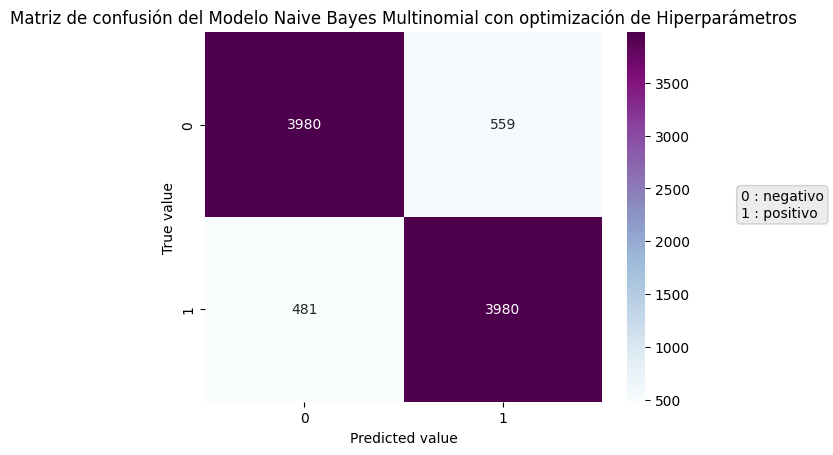

In [36]:
print('F1-Score: {}'.format(f1_score(y_test, y_pred, average='binary')))

confussionMatrix = confusion_matrix(y_true=y_test, y_pred=y_pred)
sns.heatmap(confussionMatrix,cmap='BuPu', annot=True, fmt='g')
plt.xlabel('Predicted value')
plt.ylabel('True value')
plt.title("Matriz de confusión del Modelo Naive Bayes Multinomial con optimización de Hiperparámetros")
plt.text(2.7, 1, f"0 : {labelEncoder.inverse_transform([0])[0]}\n1 : {labelEncoder.inverse_transform([1])[0]}", bbox=dict(boxstyle='round', facecolor='grey', alpha=0.15))
plt.show()

Mostramos las distintas métricas

In [37]:
accuracy = accuracy_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)

print(f"Accuracy: {str(accuracy)}")
print(f"Recall: {str(recall)}")
print(f"Precision: {str(precision)}")
print(f"f1 score: {str(f1)}")

Accuracy: 0.8844444444444445
Recall: 0.8921766420085183
Precision: 0.8768451200705001
f1 score: 0.8844444444444444


Realizamos las predicciones de los datos que vamos a submitear a kaggle

In [38]:
y_pred = multinomialNBPipeline.predict(criticsTest["review"])

Agrupamos en el dataframe los valores predichos decodeados con el label encoder

In [39]:
kaggleResult = criticsTest.copy()
kaggleResult.drop(columns=["review"], inplace=True)

kaggleResult["sentimiento"] = labelEncoder.inverse_transform(y_pred)

kaggleResult.head(2)

,ID,sentimiento
0,60000,negativo
1,60001,negativo


Para exportar a Kaggle exportamos el csv. El `runNumber` es sólo un número que ponemos para no pisar los submits

In [40]:
kaggleResult.to_csv(f"submit_{runNumber}_grupo16_gpwin_naive_bayes_multinomial.csv", index=False)

Guardamos una serialización del modelo

In [41]:
filename = f'./naive_bayes_multinomial_model_{runNumber}.joblib'
modelInfo = {'model': multinomialNBPipeline}

joblib.dump(modelInfo, filename)

['./naive_bayes_multinomial_model_4.joblib']

## Modelo Random Forest con optimización de hiperparámetros

Similar al Naive Bayes con optimización de hiperparámetros detallado arriba, creamos una pipeline con un CountVectorizer y un TfidfTransformer pero con un predictor que será un clasificador de tipo Random Forest

La optimización de hiperparámetros será de manera bayesiana con la librería optuna. Para el CountVectorizer y el TfidfTransformer se optimizarán los mismos parámetros que con el Naives Bayes, y para el Random Forest se optimizarán los siguientes parámetros:
- n_estimators: cantidad de árboles
- criterion: forma de medir la calidad de un split de un árbol
- min_samples_split: cantidad mínima de muestras requeridas para hacer el split de un nodo
- min_samples_leaf: cantidad mínima de muestras requeridas para estar en un nodo hoja

Creamos la función objetivo que vamos a optimizar

In [29]:
def objective(trial):

    parametersVectorizer = {
        'strip_accents': trial.suggest_categorical('strip_accents', ['ascii', 'unicode', None]),
        'lowercase': trial.suggest_categorical('lowercase', [True, False]),
        'ngram_range': trial.suggest_categorical('ngram_range', [(1,1), (1,2), (2,2)]),
        'binary': trial.suggest_categorical('binary', [True, False]),
        'analyzer': 'word'
    }

    parametersTransformer = {
        'norm': trial.suggest_categorical('norm', ['l1', 'l2', None]),
        'use_idf': trial.suggest_categorical('use_idf', [True, False]),
        'sublinear_tf': trial.suggest_categorical('sublinear_tf', [True, False]),
    }

    parametersModel = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 900, step=5),
        'criterion': trial.suggest_categorical('criterion', ['gini', 'entropy', 'log_loss']),
        'min_samples_split' : trial.suggest_int('min_samples_split', 2, 32, step=1),
        'min_samples_leaf' : trial.suggest_int('min_samples_leaf', 1, 10, step=1),
        'n_jobs': -1,
        'random_state': 1
    }

    rfPipeline = Pipeline(steps=[
        ('vectorizer', CountVectorizer(**parametersVectorizer)),
        ('tfidfTransformer', TfidfTransformer(**parametersTransformer)),
        ('randomForest', RandomForestClassifier(**parametersModel))
    ])

    rfPipeline.fit(x_train, y_train)
    y_pred = rfPipeline.predict(x_test)

    return f1_score(y_test, y_pred, average='binary')


Creamos un study que va a ser donde corramos el "estudio de maximizar la función objetivo" definida arriba (que optimiza el f1 score)

In [30]:
study = optuna.create_study(direction='maximize')

[I 2023-11-19 09:32:30,330] A new study created in memory with name: no-name-9a904b23-0f1b-434f-bba8-7018368b654f


El método de sampleo de hiperparámetros que seguirá la optimización bayesiana será con el tree-structured Parzen estimators -TPE

In [31]:
study.sampler.__class__.__name__

'TPESampler'

Ejecutamos el estudio

In [ ]:
study.optimize(objective, n_trials=100)

Las 100 iteraciones del estudio tardaron 7.7 horas en total

Seleccionamos el mejor trial (intento) con el mejor score y el mejor conjunto de hiperparámetros

In [33]:
bestTrial = study.best_trial
bestScore = bestTrial.value
hyperparameters = bestTrial.params

print('Cantidad de trials total: {}'.format(len(study.trials)))
print('Mejor f1score: ' + str(bestScore) + "\n")

for param, value in hyperparameters.items():
    print(f"{param}: {value}")

Cantidad de trials total: 100
Mejor f1score: 0.8727031215408457

strip_accents: ascii
lowercase: True
ngram_range: (1, 2)
binary: False
norm: None
use_idf: True
sublinear_tf: True
n_estimators: 840
criterion: entropy
min_samples_split: 23
min_samples_leaf: 3


Recreamos una pipeline con estos mejores parámetros

In [26]:
runNumber = 3

parametersVectorizer = {
    'strip_accents': hyperparameters["strip_accents"],
    'lowercase': hyperparameters["lowercase"],
    'ngram_range': hyperparameters["ngram_range"],
    'binary': hyperparameters["binary"],
    'analyzer': 'word'
}

parametersTransformer = {
    'norm': hyperparameters["norm"],
    'use_idf': hyperparameters["use_idf"],
    'sublinear_tf': hyperparameters["sublinear_tf"],
}

parametersModel = {
    'n_estimators': hyperparameters["n_estimators"],
    'criterion': hyperparameters["criterion"],
    'min_samples_split' : hyperparameters["min_samples_split"],
    'min_samples_leaf' : hyperparameters["min_samples_leaf"],
    'n_jobs': -1,
    'random_state': 1
}

rfPipeline = Pipeline(steps=[
    ('vectorizer', CountVectorizer(**parametersVectorizer)),
    ('tfidfTransformer', TfidfTransformer(**parametersTransformer)),
    ('randomForest', RandomForestClassifier(**parametersModel))
])

rfPipeline.fit(x_train, y_train)

Pipeline(steps=[('vectorizer',
                 CountVectorizer(ngram_range=(1, 2), strip_accents='ascii')),
                ('tfidfTransformer',
                 TfidfTransformer(norm=None, sublinear_tf=True)),
                ('randomForest',
                 RandomForestClassifier(criterion='entropy', min_samples_leaf=3,
                                        min_samples_split=23, n_estimators=840,
                                        n_jobs=-1, random_state=1))])

Esta es la misma predicción de test que se realizó durante el estudio

In [27]:
y_pred = rfPipeline.predict(x_test)

Imprimimos la matriz de confusión. Se agrega una caja de texto con las equivalencias entre las etiquetas numéricas y el sentimiento

F1-Score: 0.8727031215408457


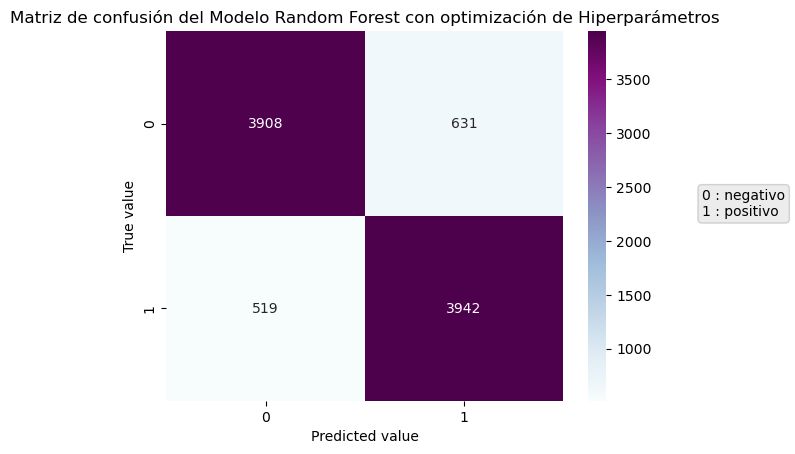

In [28]:
print('F1-Score: {}'.format(f1_score(y_test, y_pred, average='binary')))

confussionMatrix = confusion_matrix(y_true=y_test, y_pred=y_pred)
sns.heatmap(confussionMatrix,cmap='BuPu', annot=True, fmt='g')
plt.xlabel('Predicted value')
plt.ylabel('True value')
plt.title("Matriz de confusión del Modelo Random Forest con optimización de Hiperparámetros")
plt.text(2.7, 1, f"0 : {labelEncoder.inverse_transform([0])[0]}\n1 : {labelEncoder.inverse_transform([1])[0]}", bbox=dict(boxstyle='round', facecolor='grey', alpha=0.15))
plt.show()

Mostramos las distintas métricas

In [30]:
accuracy = accuracy_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)

print(f"Accuracy: {str(accuracy)}")
print(f"Recall: {str(recall)}")
print(f"Precision: {str(precision)}")
print(f"f1 score: {str(f1)}")

Accuracy: 0.8722222222222222
Recall: 0.8836583725622058
Precision: 0.862016181937459
f1 score: 0.8727031215408457


Realizamos las predicciones de los datos que vamos a submitear a kaggle

In [38]:
y_pred = rfPipeline.predict(criticsTest["review"])

Agrupamos en el dataframe los valores predichos decodeados con el label encoder

In [39]:
kaggleResult = criticsTest.copy()
kaggleResult.drop(columns=["review"], inplace=True)

kaggleResult["sentimiento"] = labelEncoder.inverse_transform(y_pred)

kaggleResult.head(2)

,ID,sentimiento
0,60000,negativo
1,60001,negativo


Para exportar a Kaggle exportamos el csv. El `runNumber` es sólo un número que ponemos para no pisar los submits

In [40]:
kaggleResult.to_csv(f"submit_{runNumber}_grupo16_gpwin_random_forest.csv", index=False)

Guardamos una serialización del modelo

In [31]:
filename = f'./random_forest_model_{runNumber}.joblib'
modelInfo = {'model': rfPipeline}

joblib.dump(modelInfo, filename)

['./random_forest_model_3.joblib']

## Modelo XGBoost con optimización de hiperparámetros

Similar al Random Forest con optimización de hiperparámetros detallado arriba, creamos una pipeline con un CountVectorizer y un TfidfTransformer pero con un predictor que será un clasificador de tipo XGBoost

La optimización de hiperparámetros será de manera bayesiana con la librería optuna. Para el CountVectorizer y el TfidfTransformer se optimizarán los mismos parámetros que con el Random Forest y el Naive Bayes, y para este XGBoost se optimizarán los siguientes parámetros:

- max_depth: profundidad máxima para los árboles base
- learning_rate: learning rate del boosting (el eta del xgb)
- n_estimators: cantidad de árboles sucesivos (boosting rounds)
- min_child_weight: mínima suma de pesos necesaria para tener un nodo hijo
- gamma: (también llamado min_split_loss) es la reducción mínima del loss para hacer unaotra partición en un nodo hoja de un árbol
- subsample: ratio de toma de una submuestra de la data de training para evitar overfitting
- colsample_bytree: similar a subsample pero para columnas en lugar de filas
- reg_alpha: regularización l1
- reg_lambda: regularización l2
- eval_metric: será la métrica que el modelo utilice para evaluar su performance durante training, lo usará para determinar cuándo parar
- use_label_encoder: el label encoder interno de xgboost se deprecó, así que lo seteamos en false para prevenir warnings

Creamos la función objetivo que vamos a optimizar

In [22]:
def objective(trial):

    parametersVectorizer = {
        'strip_accents': trial.suggest_categorical('strip_accents', ['ascii', 'unicode', None]),
        'lowercase': trial.suggest_categorical('lowercase', [True, False]),
        'ngram_range': trial.suggest_categorical('ngram_range', [(1,1), (1,2)]),
        'binary': trial.suggest_categorical('binary', [True, False]),
        'analyzer': 'word'
    }

    parametersTransformer = {
        'norm': trial.suggest_categorical('norm', ['l1', None]),
        'use_idf': trial.suggest_categorical('use_idf', [True, False]),
        'sublinear_tf': trial.suggest_categorical('sublinear_tf', [True, False]),
    }

    parametersModel = {
        'max_depth': trial.suggest_int('max_depth', 2, 7),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
        'n_estimators': trial.suggest_int('n_estimators', 500, 1000, step=5),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'gamma': trial.suggest_loguniform('gamma', 1e-8, 0.1),
        'subsample': trial.suggest_loguniform('subsample', 0.7, 1.0),
        'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-8, 0.2),
        'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-8, 0.2),
        'eval_metric': ['auc'],
        'use_label_encoder': False,
        'device': 'cuda:0',
        'n_jobs': -1
    }

    xgboostPipeline = Pipeline(steps=[
        ('vectorizer', CountVectorizer(**parametersVectorizer)),
        ('tfidfTransformer', TfidfTransformer(**parametersTransformer)),
        ('xgboost', XGBClassifier(**parametersModel))
    ])

    xgboostPipeline.fit(x_train, y_train)
    y_pred = xgboostPipeline.predict(x_test)

    score = f1_score(y_test, y_pred, average='binary')

    return score

Creamos un study que va a ser donde corramos el "estudio de maximizar la función objetivo" definida arriba (que optimiza el f1 score)

In [23]:
study = optuna.create_study(direction='maximize')

[I 2023-11-20 22:12:51,487] A new study created in memory with name: no-name-cbaed2bf-fef2-4362-8303-cf0e52178da8


El método de sampleo de hiperparámetros que seguirá la optimización bayesiana será con el tree-structured Parzen estimators -TPE

In [50]:
study.sampler.__class__.__name__

'TPESampler'

Corremos el estudio

In [ ]:
study.optimize(objective, n_trials=20)

Corremos 20 trials más del estudio

In [ ]:
study.optimize(objective, n_trials=20)

Las 40 iteraciones del estudio tardaron 13.1 horas en total

Seleccionamos el mejor trial (intento) con el mejor score y el mejor conjunto de hiperparámetros

In [52]:
bestTrial = study.best_trial
bestScore = bestTrial.value
hyperparameters = bestTrial.params

print('Cantidad de trials total: {}'.format(len(study.trials)))
print('Mejor f1score: ' + str(bestScore) + "\n")

for param, value in hyperparameters.items():
    print(f"{param}: {value}")

Cantidad de trials total: 40
Mejor f1score: 0.8820535516707236

strip_accents: unicode
lowercase: False
ngram_range: (1, 2)
binary: True
norm: None
use_idf: False
sublinear_tf: False
max_depth: 6
learning_rate: 0.15805841098188547
n_estimators: 870
min_child_weight: 8
gamma: 9.314490228855616e-07
subsample: 0.7514171516809955
reg_alpha: 0.058655370564501784
reg_lambda: 0.00037164056792145917


Recreamos una pipeline con estos mejores parámetros

In [51]:
runNumber = 6

parametersVectorizer = {
    'strip_accents': hyperparameters["strip_accents"],
    'lowercase': hyperparameters["lowercase"],
    'ngram_range': hyperparameters["ngram_range"],
    'binary': hyperparameters["binary"],
    'analyzer': 'word'
}

parametersTransformer = {
    'norm': hyperparameters["norm"],
    'use_idf': hyperparameters["use_idf"],
    'sublinear_tf': hyperparameters["sublinear_tf"],
}

parametersModel = {
    'max_depth': hyperparameters["max_depth"],
    'learning_rate': hyperparameters["learning_rate"],
    'n_estimators': hyperparameters["n_estimators"],
    'min_child_weight': hyperparameters["min_child_weight"],
    'gamma': hyperparameters["gamma"],
    'subsample': hyperparameters["subsample"],
    'reg_alpha': hyperparameters["reg_alpha"],
    'reg_lambda': hyperparameters["reg_lambda"],
    'eval_metric': 'mlogloss',
    'use_label_encoder': False,
    'device': 'cuda:0',
    'n_jobs': -1
}

xgboostPipeline = Pipeline(steps=[
    ('vectorizer', CountVectorizer(**parametersVectorizer)),
    ('tfidfTransformer', TfidfTransformer(**parametersTransformer)),
    ('xgboost', XGBClassifier(**parametersModel))
])

xgboostPipeline.fit(x_train, y_train)

Esta es la misma predicción de test que se realizó durante el estudio

In [42]:
y_pred = xgboostPipeline.predict(x_test)

Imprimimos la matriz de confusión. Se agrega una caja de texto con las equivalencias entre las etiquetas numéricas y el sentimiento

F1-Score: 0.8820535516707236


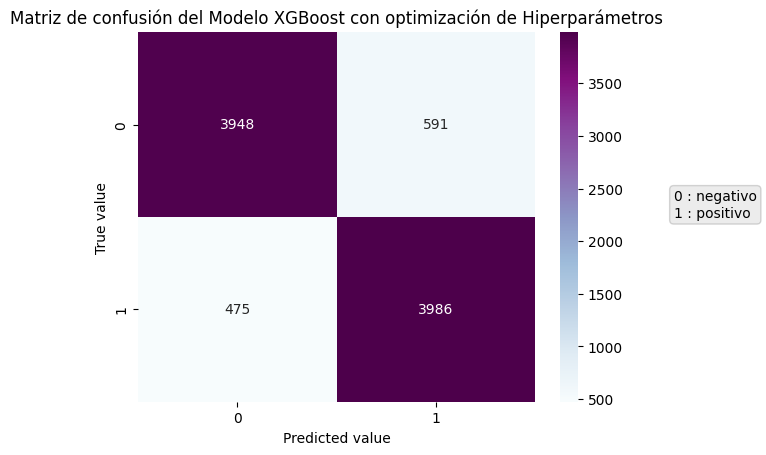

In [44]:
print('F1-Score: {}'.format(f1_score(y_test, y_pred, average='binary')))

confussionMatrix = confusion_matrix(y_true=y_test, y_pred=y_pred)
sns.heatmap(confussionMatrix,cmap='BuPu', annot=True, fmt='g')
plt.xlabel('Predicted value')
plt.ylabel('True value')
plt.title("Matriz de confusión del Modelo XGBoost con optimización de Hiperparámetros")
plt.text(2.7, 1, f"0 : {labelEncoder.inverse_transform([0])[0]}\n1 : {labelEncoder.inverse_transform([1])[0]}", bbox=dict(boxstyle='round', facecolor='grey', alpha=0.15))
plt.show()

Mostramos las distintas métricas

In [45]:
accuracy = accuracy_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)

print(f"Accuracy: {str(accuracy)}")
print(f"Recall: {str(recall)}")
print(f"Precision: {str(precision)}")
print(f"f1 score: {str(f1)}")

Accuracy: 0.8815555555555555
Recall: 0.8935216319210939
Precision: 0.8708761197290802
f1 score: 0.8820535516707236


Realizamos las predicciones de los datos que vamos a submitear a kaggle

In [46]:
y_pred = xgboostPipeline.predict(criticsTest["review"])

Agrupamos en el dataframe los valores predichos decodeados con el label encoder

In [47]:
kaggleResult = criticsTest.copy()
kaggleResult.drop(columns=["review"], inplace=True)

kaggleResult["sentimiento"] = labelEncoder.inverse_transform(y_pred)

kaggleResult.head(2)

,ID,sentimiento
0,60000,positivo
1,60001,negativo


Para exportar a Kaggle exportamos el csv. El `runNumber` es sólo un número que ponemos para no pisar los submits

In [48]:
kaggleResult.to_csv(f"submit_{runNumber}_grupo16_gpwin_xgboost.csv", index=False)

Guardamos una serialización del modelo

In [49]:
filename = f'./xgboost_model_{runNumber}.joblib'
modelInfo = {'model': xgboostPipeline}

joblib.dump(modelInfo, filename)

['./xgboost_model_6.joblib']